In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from init_objects import *
from simfinmodel import *

# Decoupling fundamentals

Based on Minsky’s evolution from Commercial Capitalism to Money Manager Capitalism, there is seems to have be another step in the evolution of capitalism. This change has taken place over the last two decades and Minsky would probably have coined the term “Index Capitalism”. 

More and more of the investment capital is moving into index management, near index management or following different quantitative algorithms (like momentum and mean reversion). According to JP Morgan only 10% of the trading volume today are done by fundamental investors. 

### How will this change the dynamics and ultimately the robustness of financial markets? 

The classic market mechanism is that investors have a view on the fundamental value of a company, and as the prices fall, the number of buyers increases as the price gets more attractive etc. This creates a form of self-stabilizing mechanism in the markets. 

In the index capitalism the majority of capital is following mechanical rules which are disconnected from the underlying investee companies. If the fundamental investors are too few and far between, their stabilizing effect on the financial markets will be marginal. 

Instead the market dynamics will be driven by the relative size of investment strategies (such as trend following and mean reversion) and the capital flows to and from index funds. In the past these factor were dominated by the fundamental investors. Market consequences of index capitalism The change in markets towards index capitalism is gradual, but at some point the system enters into a state where the chance of instability increases dramatically. 

* Instability: The system could become instable in some situations depending on the relative weighting between different trading strategies or due to the introduction of new trading strategies that are widely adapted. 
* Dynamics: With a greater disconnect between fundamental value of a stock and the stock market valuation, will lead to new type of dynamics on the financial markets. Increased correlation between stocks in same sector (despite different quality of stocks). Deviations from fair-value will be much longer and more persistent.
* Flows: With a large portion of pension and insurance money invested in index strategies, the flows (in and out of the index funds) will drive the stock market (at the beta level). Increasing the stocks covariation with the market. Sentiment driven flows will create large amounts of volatility. 

A decoupling of stock market dynamics from stock fundamentals will have a massive impact on how institutional investors should behave in the short- and medium-term as well as assessing extreme tail risk events. The market dynamics of index capitalism might explain why the realized return from absolute return strategies (such as long-short equities) have been going down.

The demise of fundamental investors also impacts the governance of listed corporates. Fewer investors are there to hold the executive management to account and bad companies will not quickly punished by the market. This leads to that problems will linger along and hampers long-term growth. What can investors do?

A good understanding of the new dynamics under index capitalism is necessary. Affects both alpha strategies as well as Strategic and Tactical allocation of market risks. Investors we need to be better at dealing with increased uncertainty. For example, have we passed the instability threshold and in that case what are good indicators to better manage the increased instability?


## Parameters

In [18]:
NRUNS = 1
parameters = {
    # global parameters
    "n_traders": 5000,
    "ticks": 1000,
    "fundamental_value": 100,
    "std_fundamental": 0.1,
    "std_noise": 0.01,
    "std_vol": 4,
    "max_order_expiration_ticks": 30,
    # trader parameters
    "w_fundamentalists": 2.0,
    "w_momentum": 1.0,
    "w_random": 2.0,
    "w_mean_reversion": 1.0,
    "w_buy_hold": 0.0,
    "spread_max": 0.004087, # from Riordann & Storkenmaier 2012
    # initial values
    "horizon_min": 1,
    "horizon_max": 4,
    "av_return_interval_max": 4,
    "init_spread": (1, 1),
}

## Baseline Monte Carlo Simulations

In [19]:
traders = []
obs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects(parameters)
    traders, orderbook = sim_fin_model(traders, orderbook, parameters, seed)
    traders.append(traders)
    obs.append(orderbook)

## Dynamics

In [20]:
window = 10
close_price = []
returns = []
autocorr_returns = []
autocorr_abs_returns = []
returns_volatility = []
volume = []
fundamentals = []
for ob in obs: # record
    # close price
    close_price.append(ob.tick_close_price)
    # returns
    r = pd.Series(np.array(ob.tick_close_price)).pct_change()
    returns.append(r)
    # autocorrelation returns
    ac_r = [r.autocorr(lag=lag) for lag in range(25)]
    autocorr_returns.append(ac_r)
    # autocorrelation absolute returns
    absolute_returns = pd.Series(r).abs()
    autocorr_abs_returns.append([absolute_returns.autocorr(lag=lag) for lag in range(25)])
    # volatility of returns
    roller_returns = r.rolling(window)
    returns_volatility.append(roller_returns.std(ddof=0))
    # volume
    volume.append([sum(volumes) for volumes in ob.transaction_volumes_history])
    # fundamentals 
    fundamentals.append(ob.fundamental)
mc_prices = pd.DataFrame(close_price).transpose()
mc_returns = pd.DataFrame(returns).transpose()
mc_autocorr_returns = pd.DataFrame(autocorr_returns).transpose()
mc_autocorr_abs_returns = pd.DataFrame(autocorr_abs_returns).transpose()
mc_volatility = pd.DataFrame(returns_volatility).transpose()
mc_volume = pd.DataFrame(volume).transpose()
mc_fundamentals = pd.DataFrame(fundamentals).transpose()

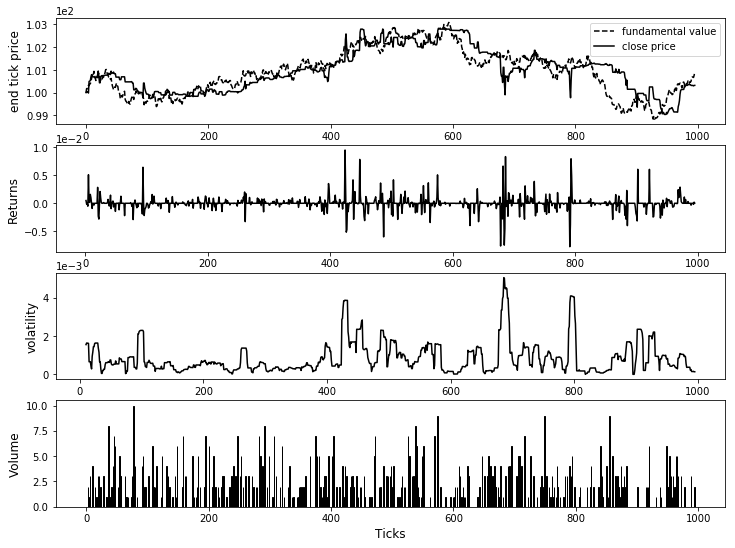

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,9))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='fundamental value')
ax1.plot(mc_prices.index, mc_prices.mean(axis=1), 'k-', label='close price')
ax1.set_ylabel('end tick price', fontsize='12')
ax1.legend()

ax2.plot(mc_returns.index, mc_returns.mean(axis=1), 'k-')
ax2.set_ylabel('Returns', fontsize='12')

ax3.plot(mc_volatility.index, mc_volatility.mean(axis=1), 'k-')
ax3.set_ylabel('volatility', fontsize='12')

ax4.bar(mc_volume.index, mc_volume.mean(axis=1), color='k', edgecolor='k')
ax4.set_ylabel('Volume', fontsize='12')
ax4.set_xlabel('Ticks', fontsize='12')

for ax in [ax1, ax2, ax3, ax4]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

# Basic stylized facts

* **No autocorrelation** in returns
* **Volatility clustering** (marked by slowly decaying absolute autocorrelation)

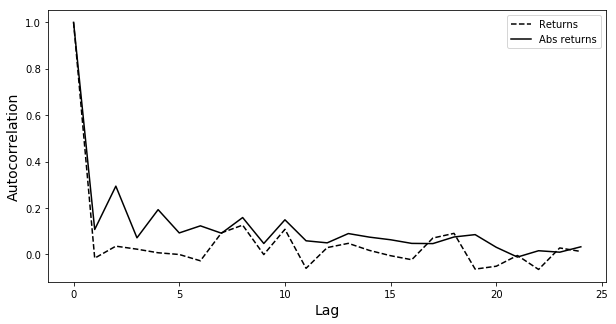

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

lenght = 20

ax1.plot(mc_autocorr_returns.index, mc_autocorr_returns.mean(axis=1), 'k--', label='Returns')
ax1.fill_between(mc_autocorr_returns.index, 
                 mc_autocorr_returns.mean(axis=1)+mc_autocorr_returns.std(axis=1), 
                 mc_autocorr_returns.mean(axis=1)-mc_autocorr_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.plot(mc_autocorr_abs_returns.index, mc_autocorr_abs_returns.mean(axis=1), 'k-', label='Abs returns')
ax1.fill_between(mc_autocorr_abs_returns.index, 
                 mc_autocorr_abs_returns.mean(axis=1)+mc_autocorr_abs_returns.std(axis=1), 
                 mc_autocorr_abs_returns.mean(axis=1)-mc_autocorr_abs_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

* **Excess Kurtosis**

In [38]:
mc_prices.mean(axis=1).kurtosis()

-0.42309032060957641

# Experiments